# ProductListPriceHistory

## Import the required libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from torch.utils.data import TensorDataset, DataLoader
from common_functions import drop_sk_datetime_added_columns as drop_columns, train_model, get_engine, \
    read_data_return_df, plot_predictions, plot_feature_importance, plot_decision_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
import torch

## Connecting to the database

In [2]:
engine = get_engine()

Connection to UnitedOutdoors database successful


## Reading the data

In [3]:
sql_query = "SELECT * FROM ProductListPriceHistory"
productlistpricehistory_df = read_data_return_df(sql_query, engine)

productlistpricehistory_df.head()

,PRODUCTLISTPRICEHISTORY_sk,PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_ProductID,PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_StartDate,PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_EndDate,PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_ListPrice,PRODUCTLISTPRICEHISTORY_datetime_added
0,1,222,2011-05-31,2012-05-29,33.6442,2024-05-26 17:15:13.933
1,2,222,2012-05-30,2013-05-29,33.6442,2024-05-26 17:15:13.933
2,3,222,2013-05-30,None,34.9900,2024-05-26 17:15:13.933
3,4,228,2011-05-31,2012-05-29,33.6442,2024-05-26 17:15:13.933
4,5,228,2012-05-30,2013-05-29,33.6442,2024-05-26 17:15:13.933


In [4]:
sql_query = "SELECT * FROM Product"
product_df = read_data_return_df(sql_query, engine)

product_df.head()

,PRODUCT_sk,PRODUCT_PRODUCT_ID,PRODUCT_UNITMEASURE_SIZE_ID,PRODUCT_UNITMEASURE_WEIGHT_ID,PRODUCT_PRODUCT_SubCategoryID,PRODUCT_PRODUCTSUBCATEGORY_CategoryID,PRODUCT_PRODUCT_ModelID,PRODUCT_PRODUCTMODELILLUSTRATION_IllustrationID,PRODUCT_PRODUCTPRODUCTPHOTO_PhotoID,PRODUCT_PMPDC_DescriptionID,...,PRODUCT_PRODUCTPHOTO_LargePhotoHexString,PRODUCT_PRODUCTPHOTO_LargePhotoFileName,PRODUCT_PRODUCT_SellStartDate,PRODUCT_DATE_SellStartDateFK,PRODUCT_PRODUCT_SellEndDate,PRODUCT_DATE_SellEndDateFK,PRODUCT_PRODUCT_DiscountedDate,PRODUCT_DATE_DiscountedDateFK,PRODUCT_PRODUCT_Discontinued,PRODUCT_datetime_added
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0x474946383961F0009500F70000000000800000008000...,no_image_available_large.gif,2008-04-30,20080430,None,18000101,None,18000101,NaN,2024-05-26 17:13:33.597
1,2,2,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0x474946383961F0009500F70000000000800000008000...,no_image_available_large.gif,2008-04-30,20080430,None,18000101,None,18000101,NaN,2024-05-26 17:13:33.597
2,3,3,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0x474946383961F0009500F70000000000800000008000...,no_image_available_large.gif,2008-04-30,20080430,None,18000101,None,18000101,NaN,2024-05-26 17:13:33.597
3,4,4,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0x474946383961F0009500F70000000000800000008000...,no_image_available_large.gif,2008-04-30,20080430,None,18000101,None,18000101,NaN,2024-05-26 17:13:33.597
4,5,316,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0x474946383961F0009500F70000000000800000008000...,no_image_available_large.gif,2008-04-30,20080430,None,18000101,None,18000101,NaN,2024-05-26 17:13:33.597


## Data cleaning

In [5]:
# combining the two dataframes
combined_df = pd.merge(productlistpricehistory_df, product_df, left_on='PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_ProductID', right_on='PRODUCT_sk')

# dropping the columns
drop_columns(combined_df)

In [6]:
# drop the unnecessary columns
columns_to_drop = ['PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_ProductID', 'PRODUCT_UNITMEASURE_SIZE_ID', 'PRODUCT_UNITMEASURE_WEIGHT_ID', 'PRODUCT_PRODUCTPRODUCTPHOTO_PhotoID', 'PRODUCT_PMPDC_DescriptionID', 'PRODUCT_PRODUCT_Name', 'PRODUCT_PRODUCT_Number', 'PRODUCT_PRODUCT_MakeFlag', 'PRODUCT_PRODUCT_FinishedGoodsFlag', 'PRODUCT_PRODUCT_Color', 'PRODUCT_PRODUCTSUBCATEGORY_SubCategory', 'PRODUCT_PRODUCTCATEGORY_Category', 'PRODUCT_PRODUCTMODEL_Name', 'PRODUCT_PRODUCTMODEL_CatalogDescription', 'PRODUCT_PRODUCTMODEL_Instructions', 'PRODUCT_ILLUSTRATION_Diagram', 'PRODUCT_CULTURE_Name', 'PRODUCT_PRODUCTDESCRIPTION_Desc', 'PRODUCT_PRODUCTPRODUCTPHOTO_Primary', 'PRODUCT_PRODUCTPHOTO_ThumbnailPhoto', 'PRODUCT_PRODUCTPHOTO_ThumbnailPhotoHexString', 'PRODUCT_PRODUCTPHOTO_ThumbnailPhotoFileName', 'PRODUCT_PRODUCTPHOTO_LargePhoto', 'PRODUCT_PRODUCTPHOTO_LargePhotoHexString', 'PRODUCT_PRODUCTPHOTO_LargePhotoFileName', 'PRODUCT_PRODUCT_SellStartDate', 'PRODUCT_PRODUCT_SellEndDate', 'PRODUCT_PRODUCT_ListPrice', 'PRODUCT_PRODUCT_StandardCost']

combined_df.drop(columns=columns_to_drop, inplace=True)

In [7]:
# converting the dates to integers (2013-05-30 to 20130530)
combined_df.fillna(-1, inplace=True)
combined_df['PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_StartDate'] = combined_df['PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_StartDate'].astype(str).str.replace('-', '').astype(int)
combined_df['PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_EndDate'] = combined_df['PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_EndDate'].astype(str).str.replace('-', '').astype(int)

combined_df['PRODUCT_PRODUCT_SubCategoryID'] = combined_df['PRODUCT_PRODUCT_SubCategoryID'].astype('category').cat.codes
combined_df['PRODUCT_PMPDC_CultureID'] = combined_df['PRODUCT_PMPDC_CultureID'].astype('category').cat.codes
combined_df['PRODUCT_PRODUCT_ProductLine'] = combined_df['PRODUCT_PRODUCT_ProductLine'].astype('category').cat.codes
combined_df['PRODUCT_PRODUCT_Size'] = combined_df['PRODUCT_PRODUCT_Size'].astype('category').cat.codes
combined_df['PRODUCT_PRODUCT_Class'] = combined_df['PRODUCT_PRODUCT_Class'].astype('category').cat.codes
combined_df['PRODUCT_PRODUCT_Style'] = combined_df['PRODUCT_PRODUCT_Style'].astype('category').cat.codes

In [8]:
# dropping all rows where PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_ListPrice is null/-1
combined_df = combined_df[combined_df['PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_ListPrice'] != -1]

In [9]:
combined_df.head()

,PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_StartDate,PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_EndDate,PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_ListPrice,PRODUCT_PRODUCT_ID,PRODUCT_PRODUCT_SubCategoryID,PRODUCT_PRODUCTSUBCATEGORY_CategoryID,PRODUCT_PRODUCT_ModelID,PRODUCT_PRODUCTMODELILLUSTRATION_IllustrationID,PRODUCT_PMPDC_CultureID,PRODUCT_PRODUCT_SafetyStockLevel,PRODUCT_PRODUCT_ReorderPoint,PRODUCT_PRODUCT_Size,PRODUCT_PRODUCT_Weight,PRODUCT_PRODUCT_DaysToManufacture,PRODUCT_PRODUCT_ProductLine,PRODUCT_PRODUCT_Class,PRODUCT_PRODUCT_Style,PRODUCT_DATE_SellStartDateFK,PRODUCT_DATE_SellEndDateFK,PRODUCT_DATE_DiscountedDateFK
0,20110531,20120529,33.6442,707,28,4.0,33.0,-1.0,2,4.0,3.0,0,-1.0,0.0,3,0,0,20110531,18000101,18000101
1,20120530,20130529,33.6442,707,28,4.0,33.0,-1.0,2,4.0,3.0,0,-1.0,0.0,3,0,0,20110531,18000101,18000101
2,20130530,1,34.9900,707,28,4.0,33.0,-1.0,2,4.0,3.0,0,-1.0,0.0,3,0,0,20110531,18000101,18000101
3,20110531,20120529,33.6442,708,28,4.0,33.0,-1.0,2,4.0,3.0,0,-1.0,0.0,3,0,0,20110531,18000101,18000101
4,20120530,20130529,33.6442,708,28,4.0,33.0,-1.0,2,4.0,3.0,0,-1.0,0.0,3,0,0,20110531,18000101,18000101


## Data preprocessing

### Splitting the data

In [10]:
# splitting the data
X = combined_df.drop(columns=['PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_ListPrice'])
y = combined_df['PRODUCTLISTPRICEHISTORY_PRODUCTLISTPRICEHISTORY_ListPrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Training

### Linear Regression

In [11]:
# scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# fitting the model
lr_model = LinearRegression()

lr_model.fit(X_train_scaled, y_train)

LinearRegression()

In [13]:
# predicting the values
lr_y_pred = lr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [14]:
# calculating the metrics
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_r2 = r2_score(y_test, lr_y_pred)

print(f'Mean Squared Error: {lr_mse}')
print(f'R2 Score: {lr_r2}')

Mean Squared Error: 305143.03405833506
R2 Score: 0.6124659724802324


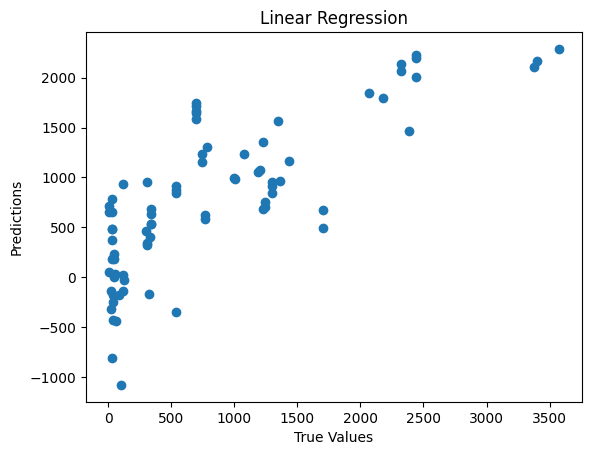

In [15]:
# visualizing the results
plot_predictions(y_test, lr_y_pred, 'Linear Regression', 'ProductListPriceHistory_Listprice', 'lr')

In [16]:
# dataframe with the predictions and the actual values, plus other metrics
lr_results = pd.DataFrame({'Actual': y_test, 'Predicted': lr_y_pred})
lr_results['Difference'] = lr_results['Actual'] - lr_results['Predicted']
lr_results['Absolute Difference'] = np.abs(lr_results['Difference'])
lr_results['Squared Difference'] = lr_results['Difference'] ** 2

lr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
78,1364.5000,967.936082,396.563918,396.563918,1.572629e+05
371,1700.9900,495.992920,1204.997080,1204.997080,1.452018e+06
248,89.9900,-176.703391,266.693391,266.693391,7.112536e+04
55,337.2200,681.049488,-343.829488,343.829488,1.182187e+05
390,101.2400,-1076.582302,1177.822302,1177.822302,1.387265e+06
...,...,...,...,...,...
364,2384.0700,1460.300843,923.769157,923.769157,8.533495e+05
82,1240.4545,707.305713,533.148787,533.148787,2.842476e+05
114,699.0982,1745.982257,-1046.884057,1046.884057,1.095966e+06
3,33.6442,479.414965,-445.770765,445.770765,1.987116e+05


In [17]:
# printing the average absolute difference
print(f'Average Absolute Difference: {lr_results["Absolute Difference"].mean()}')

Average Absolute Difference: 433.154830066174


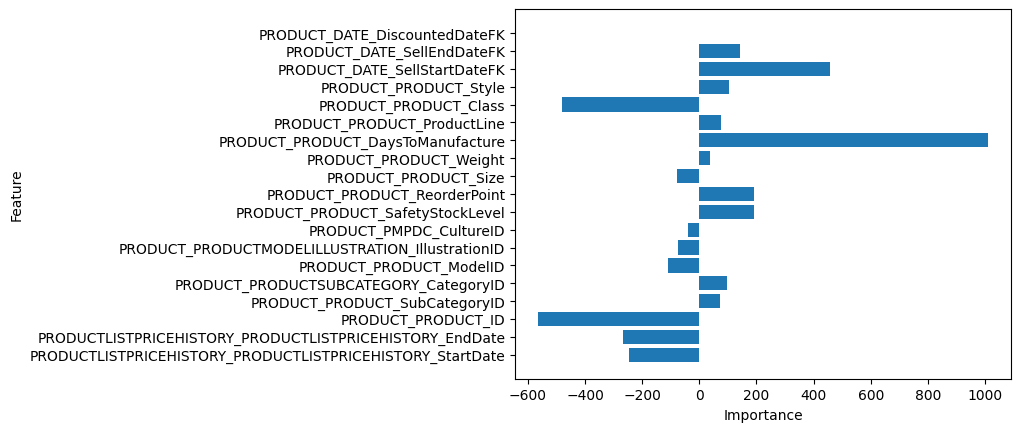

In [18]:
# plotting the feature importances, which means how much each column contributes to the prediction
plot_feature_importance(X.columns, lr_model.coef_, 'Linear Regression', 'ProductListPriceHistory_Listprice', 'lr')

### Decision Tree

In [19]:
# fitting the model
dtr_model = DecisionTreeRegressor(max_depth=5)

dtr_model.fit(X_train_scaled, y_train)

DecisionTreeRegressor(max_depth=5)

In [20]:
# predicting the values
dtr_y_pred = dtr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [21]:
# calculating the metrics
dtr_mse = mean_squared_error(y_test, dtr_y_pred)
dtr_r2 = r2_score(y_test, dtr_y_pred)
print(f'Mean Squared Error: {dtr_mse}')
print(f'R2 Score: {dtr_r2}')

Mean Squared Error: 18387.31228139381
R2 Score: 0.9766479703341024


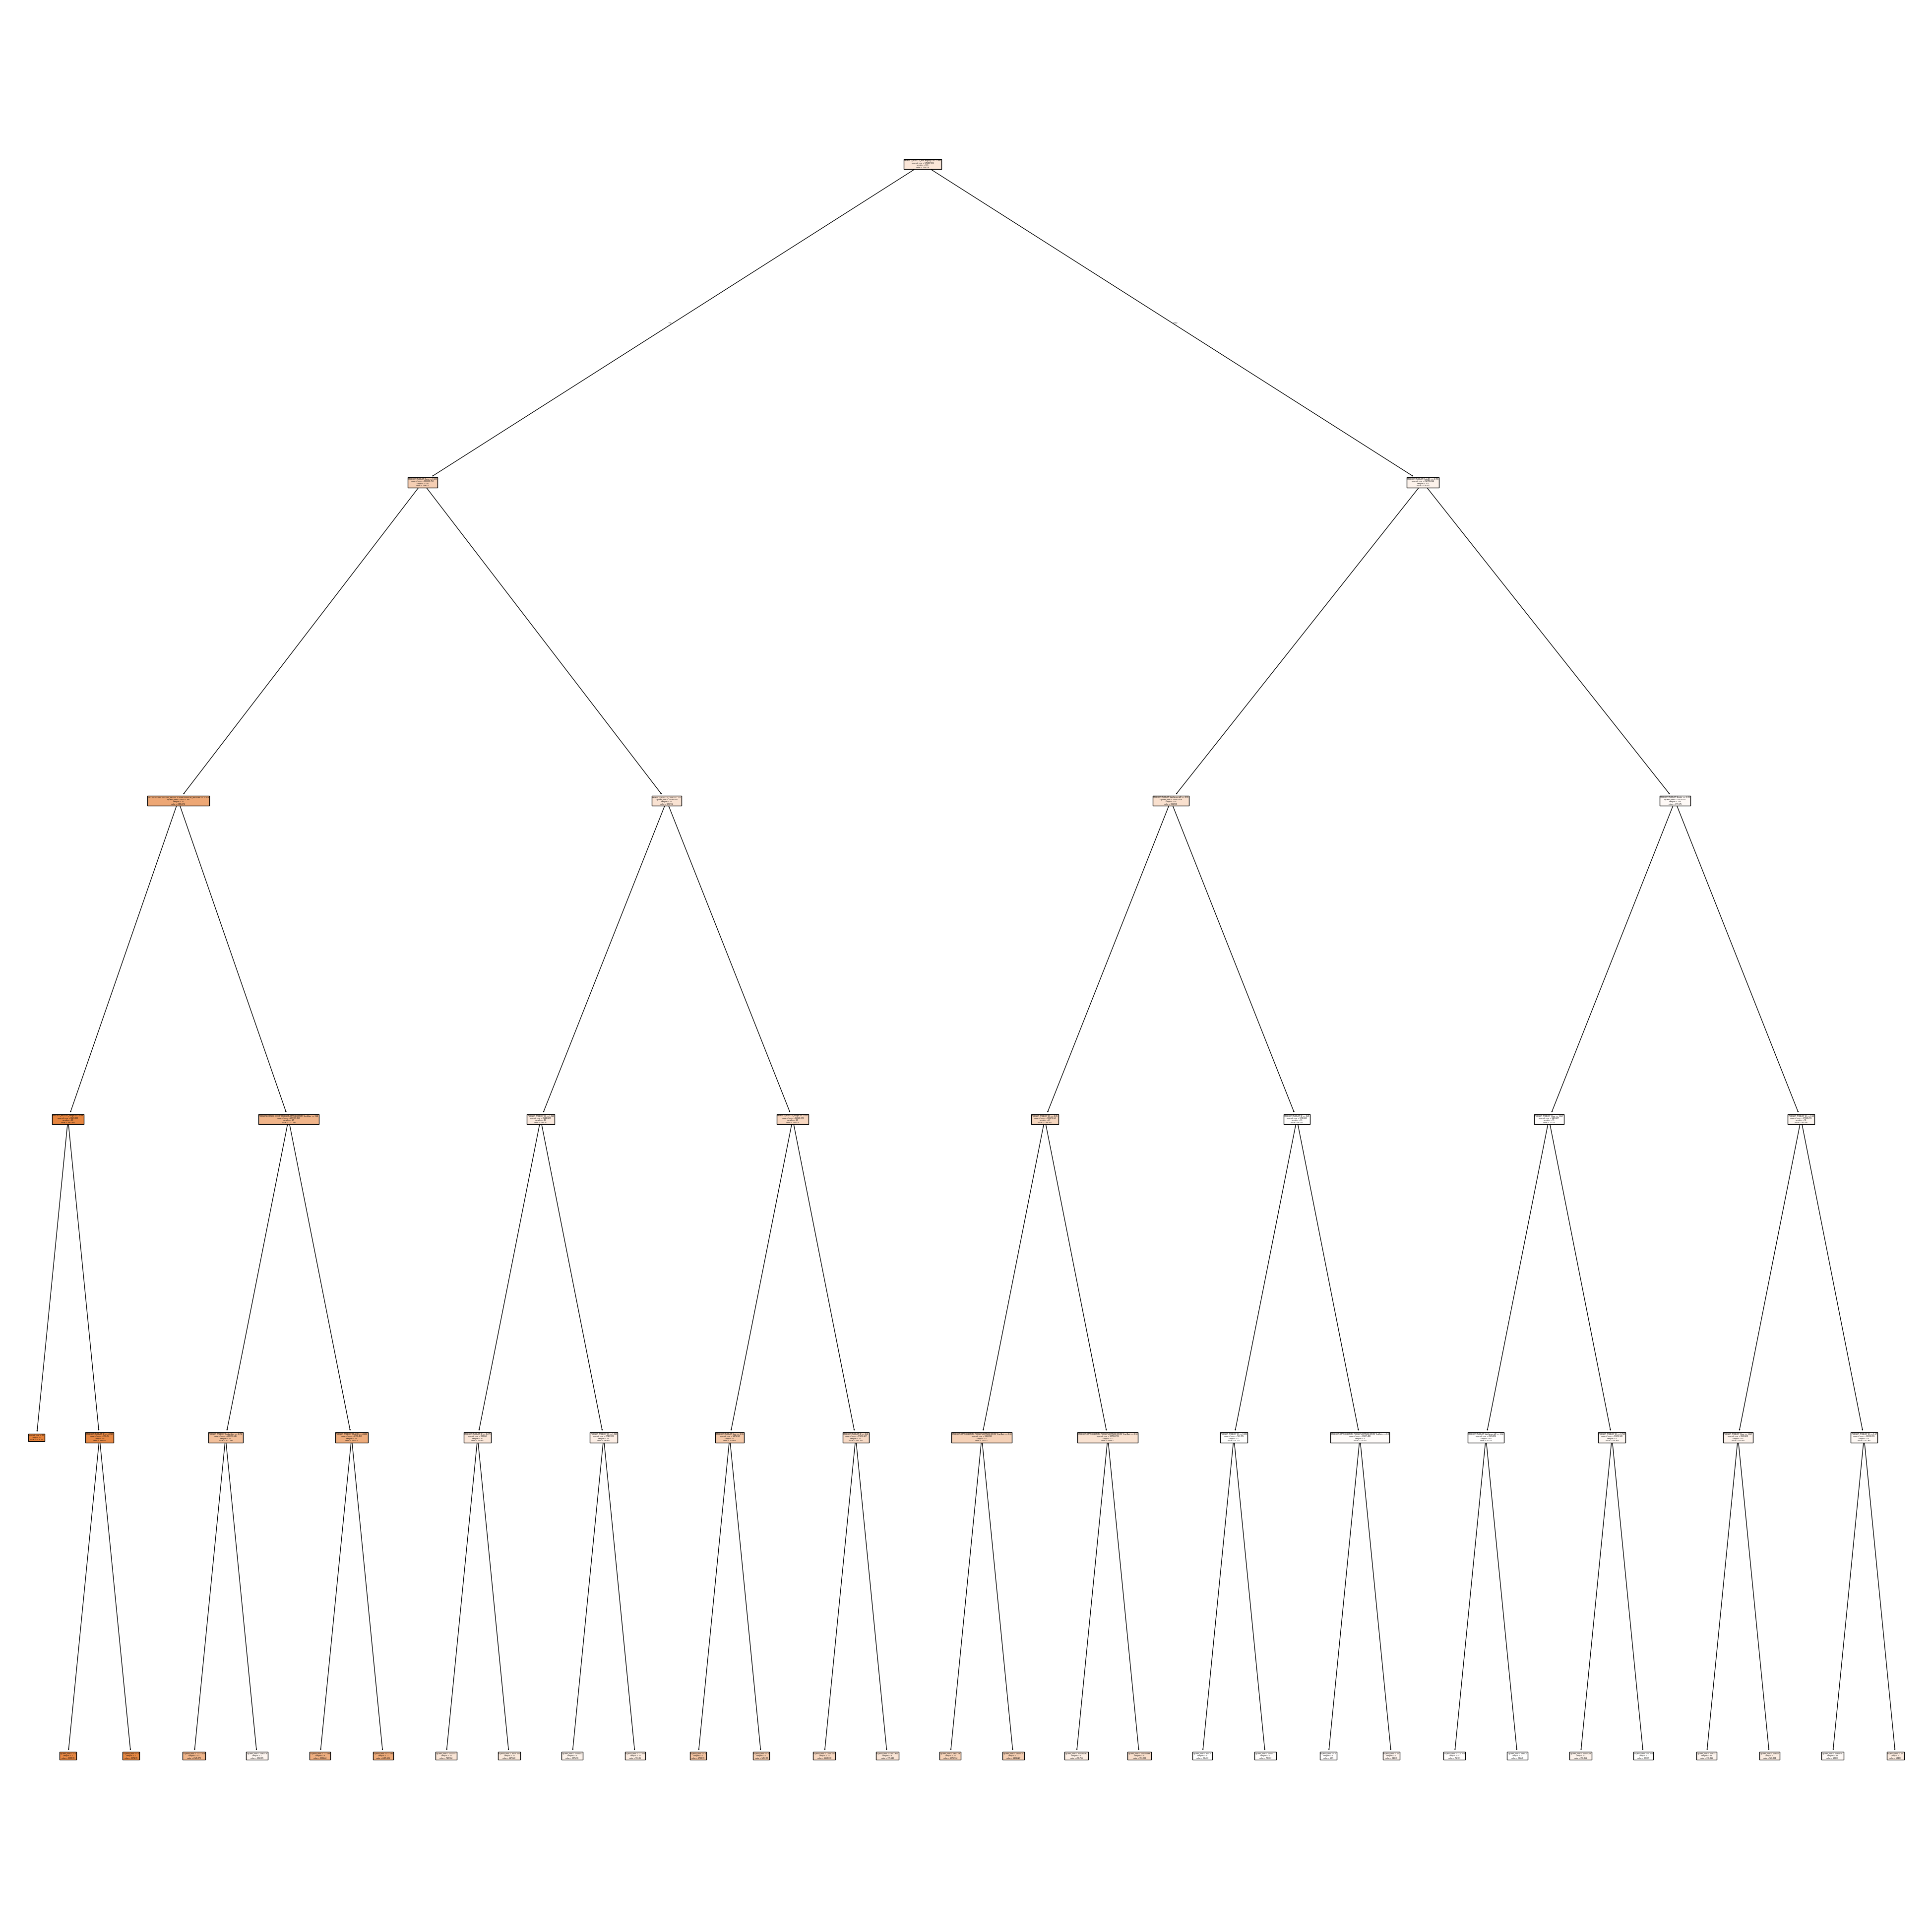

In [22]:
# visualizing the decision tree
plot_decision_tree(dtr_model, X.columns, 'Decision Tree', 'ProductListPriceHistory_Listprice', 'dt')

In [23]:
# dataframe with the predictions and the actual values, plus other metrics
dtr_results = pd.DataFrame({'Actual': y_test, 'Predicted': dtr_y_pred})
dtr_results['Difference'] = dtr_results['Actual'] - dtr_results['Predicted']
dtr_results['Absolute Difference'] = np.abs(dtr_results['Difference'])
dtr_results['Squared Difference'] = dtr_results['Difference'] ** 2

dtr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
78,1364.5000,1404.427273,-39.927273,39.927273,1594.187107
371,1700.9900,1457.990000,243.000000,243.000000,59049.000000
248,89.9900,71.160973,18.829027,18.829027,354.532245
55,337.2200,318.916073,18.303927,18.303927,335.033754
390,101.2400,594.830000,-493.590000,493.590000,243631.088100
...,...,...,...,...,...
364,2384.0700,2405.626364,-21.556364,21.556364,464.676813
82,1240.4545,1275.533900,-35.079400,35.079400,1230.564304
114,699.0982,749.563870,-50.465670,50.465670,2546.783849
3,33.6442,28.247854,5.396346,5.396346,29.120548


In [24]:
# printing the average absolute difference
print(f'Average Absolute Difference: {dtr_results["Absolute Difference"].mean()}')

Average Absolute Difference: 74.9661762092443


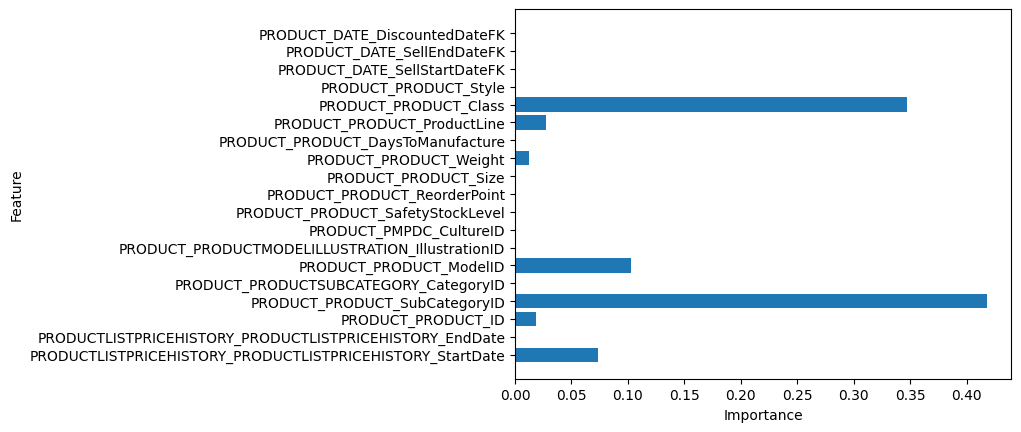

In [25]:
# plotting the feature importances, which means how much each column contributes to the prediction
plot_feature_importance(X.columns, dtr_model.feature_importances_, 'Decision Tree', 'ProductListPriceHistory_Listprice', 'dt')

### Random Forest

In [26]:
# fitting the model
rfr_model = RandomForestRegressor(n_estimators=100)

rfr_model.fit(X_train_scaled, y_train)

RandomForestRegressor()

In [27]:
# predicting the values
rfr_y_pred = rfr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [28]:
# calculating the metrics
rfr_mse = mean_squared_error(y_test, rfr_y_pred)
rfr_r2 = r2_score(y_test, rfr_y_pred)
print(f'Mean Squared Error: {rfr_mse}')
print(f'R2 Score: {rfr_r2}')

Mean Squared Error: 13122.405745072143
R2 Score: 0.9833344426005669


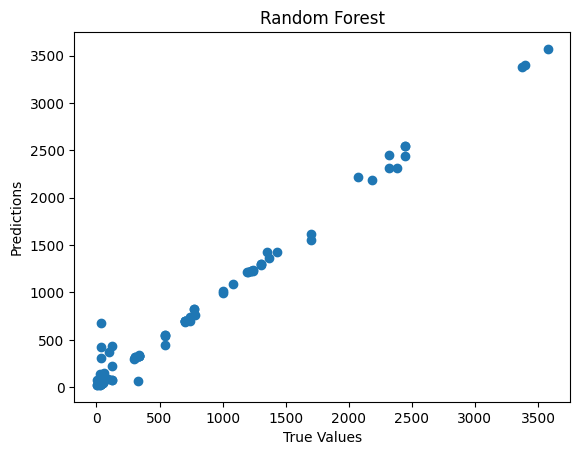

In [29]:
# plotting the results
plot_predictions(y_test, rfr_y_pred, 'Random Forest', 'ProductListPriceHistory_Listprice', 'rf')

In [30]:
# dataframe with the predictions and the actual values, plus other metrics
rfr_results = pd.DataFrame({'Actual': y_test, 'Predicted': rfr_y_pred})
rfr_results['Difference'] = rfr_results['Actual'] - rfr_results['Predicted']
rfr_results['Absolute Difference'] = np.abs(rfr_results['Difference'])
rfr_results['Squared Difference'] = rfr_results['Difference'] ** 2

rfr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
78,1364.5000,1364.571000,-0.071000,0.071000,0.005041
371,1700.9900,1557.212200,143.777800,143.777800,20672.055773
248,89.9900,86.855392,3.134608,3.134608,9.825767
55,337.2200,334.154360,3.065640,3.065640,9.398149
390,101.2400,376.401500,-275.161500,275.161500,75713.851082
...,...,...,...,...,...
364,2384.0700,2315.254400,68.815600,68.815600,4735.586803
82,1240.4545,1229.493054,10.961446,10.961446,120.153298
114,699.0982,699.530718,-0.432518,0.432518,0.187072
3,33.6442,33.116791,0.527409,0.527409,0.278161


In [31]:
# printing the average absolute difference
print(f'Average Absolute Difference: {rfr_results["Absolute Difference"].mean()}')

Average Absolute Difference: 52.07150080250145


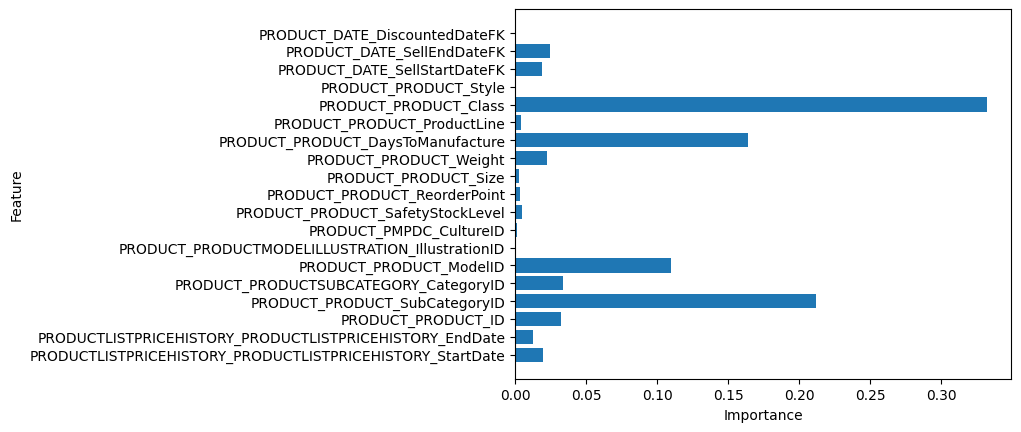

In [32]:
# plotting the feature importances, which means how much each column contributes to the prediction
plot_feature_importance(X.columns, rfr_model.feature_importances_, 'Random Forest', 'ProductListPriceHistory_Listprice', 'rf')

### Gradient Boosting

In [33]:
# fitting the model
gbr_model = GradientBoostingRegressor(n_estimators=100)

gbr_model.fit(X_train_scaled, y_train)

GradientBoostingRegressor()

In [34]:
# predicting the values
gbr_y_pred = gbr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [35]:
# calculating the metrics
gbr_mse = mean_squared_error(y_test, gbr_y_pred)
gbr_r2 = r2_score(y_test, gbr_y_pred)
print(f'Mean Squared Error: {gbr_mse}')
print(f'R2 Score: {gbr_r2}')

Mean Squared Error: 23729.682788916907
R2 Score: 0.9698631182214782


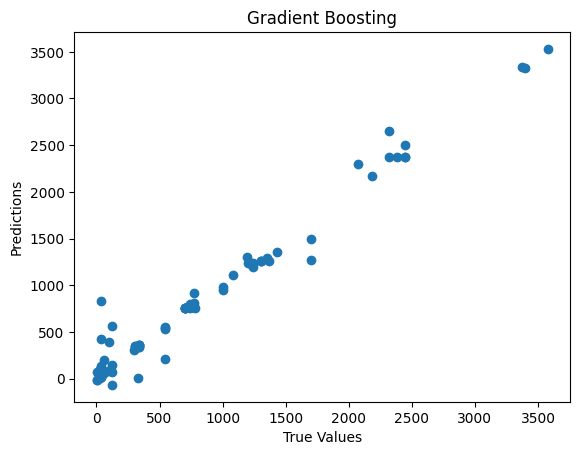

In [36]:
# plotting the results
plot_predictions(y_test, gbr_y_pred, 'Gradient Boosting', 'ProductListPriceHistory_Listprice', 'gb')

In [37]:
# dataframe with the predictions and the actual values, plus other metrics
gbr_results = pd.DataFrame({'Actual': y_test, 'Predicted': gbr_y_pred})
gbr_results['Difference'] = gbr_results['Actual'] - gbr_results['Predicted']
gbr_results['Absolute Difference'] = np.abs(gbr_results['Difference'])
gbr_results['Squared Difference'] = gbr_results['Difference'] ** 2

gbr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
78,1364.5000,1254.646613,109.853387,109.853387,12067.766531
371,1700.9900,1269.104402,431.885598,431.885598,186525.169685
248,89.9900,81.098740,8.891260,8.891260,79.054496
55,337.2200,356.160820,-18.940820,18.940820,358.754669
390,101.2400,390.428290,-289.188290,289.188290,83629.867160
...,...,...,...,...,...
364,2384.0700,2368.616818,15.453182,15.453182,238.800834
82,1240.4545,1238.375633,2.078867,2.078867,4.321689
114,699.0982,754.694341,-55.596141,55.596141,3090.930883
3,33.6442,18.971437,14.672763,14.672763,215.289965


In [38]:
# printing the average absolute difference
print(f'Average Absolute Difference: {gbr_results["Absolute Difference"].mean()}')

Average Absolute Difference: 83.16879161282944


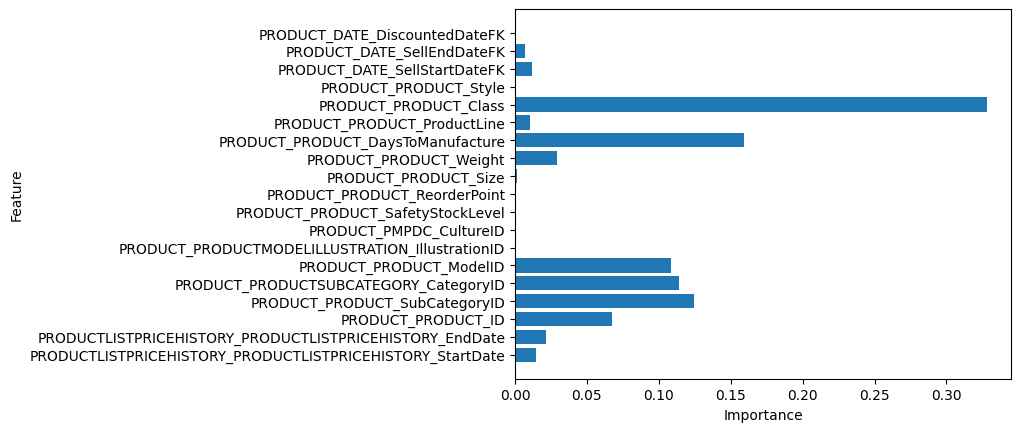

In [39]:
# plotting the feature importances, which means how much each column contributes to the prediction
plot_feature_importance(X.columns, gbr_model.feature_importances_, 'Gradient Boosting', 'ProductListPriceHistory_Listprice', 'gb')

### Pytorch Network

In [40]:
# check if the GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# converting the data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

Using device: cuda


In [41]:
p_model = torch.nn.Sequential(
    torch.nn.Linear(X_train_tensor.shape[1], 128),
    torch.nn.ReLU(),  
    torch.nn.Dropout(0.05),
    torch.nn.Linear(128, 48),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(48),  
    torch.nn.Linear(48, 1)
).to(device)

# define the loss function and the optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(p_model.parameters(), lr=0.25)

# Create TensorDatasets for training and test data
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for training and test data
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

# Train the model
train_model(p_model, criterion, optimizer, train_loader, num_epochs=1000)

Epoch 0, Loss: 333539.9375
Epoch 100, Loss: 856196.1875
Epoch 200, Loss: 570646.625
Epoch 300, Loss: 415672.09375
Epoch 400, Loss: 736603.875
Epoch 500, Loss: 571741.625
Epoch 600, Loss: 474601.8125
Epoch 700, Loss: 576470.875
Epoch 800, Loss: 1434093.25
Epoch 900, Loss: 378587.71875


#### Calculating the metrics and visualizing the results

In [42]:
# Evaluate the model
p_model.eval()
p_mse_list = []
p_r2_list = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = p_model(inputs)
        mse = mean_squared_error(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        r2 = r2_score(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        p_mse_list.append(mse)
        p_r2_list.append(r2)

# Calculate the average metrics
p_avg_mse = np.mean(p_mse_list)
p_avg_r2 = np.mean(p_r2_list)

print(f'Average Mean Squared Error: {p_avg_mse}')
print(f'Average R2 Score: {p_avg_r2}')

Average Mean Squared Error: 748369.25
Average R2 Score: -0.05193559328715006


In [43]:
# dataframe with the predictions and the actual values, plus other metrics
p_results = pd.DataFrame({'Actual': y_test_tensor.cpu().detach().numpy(), 'Predicted': p_model(X_test_tensor).cpu().detach().numpy().flatten()})
p_results['Difference'] = p_results['Actual'] - p_results['Predicted']
p_results['Absolute Difference'] = np.abs(p_results['Difference'])
p_results['Squared Difference'] = p_results['Difference'] ** 2

p_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
0,1364.500000,706.222961,658.277039,658.277039,4.333287e+05
1,1700.989990,706.222961,994.767029,994.767029,9.895614e+05
2,89.989998,706.222961,-616.232971,616.232971,3.797431e+05
3,337.220001,706.222961,-369.002960,369.002960,1.361632e+05
4,101.239998,706.222961,-604.982971,604.982971,3.660044e+05
...,...,...,...,...,...
74,2384.070068,706.222961,1677.847168,1677.847168,2.815171e+06
75,1240.454468,706.222961,534.231506,534.231506,2.854033e+05
76,699.098206,706.222961,-7.124756,7.124756,5.076215e+01
77,33.644199,706.222961,-672.578735,672.578735,4.523622e+05


In [44]:
# printing the average absolute difference
print(f'Average Absolute Difference: {p_results["Absolute Difference"].mean()}')

Average Absolute Difference: 677.5360717773438


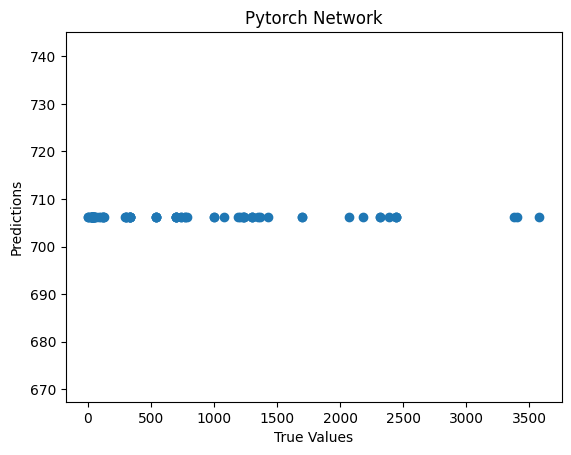

In [45]:
# plotting the results
plot_predictions(y_test_tensor.cpu().detach().numpy(), p_model(X_test_tensor).cpu().detach().numpy().flatten(), 'Pytorch Network', 'ProductListPriceHistory_Listprice', 'torch')